In [105]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# for evaluation
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [106]:
data = pd.read_csv("data/combined_expression.csv")
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,2,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,1,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,1,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,1,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,1,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [107]:
data.shape

(541, 16384)

In [108]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))

In [109]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# Confusion Matrix Plotting Function

In [72]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# 4 Hidden Layers (with batch normalization)

In [73]:
def create_model(optimizer='adam', init='normal', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)

    # first hidden layer
    model.add(Dense(hidden_layers, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    # second hidden layer
    model.add(Dense((hidden_layers*1.5), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    # third hidden layer
    model.add(Dense((hidden_layers), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    # fourth hidden layer
    model.add(Dense((hidden_layers*0.25), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [74]:
# parameters selected from previous gridsearch
model4 = KerasClassifier(build_fn=hidden4, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [75]:
history4 = model4.fit(X_train, y_train, validation_data=(X_test,y_test), shuffle=True)
y_pred4 = model4.predict(X_test)

Train on 554 samples, validate on 109 samples
Epoch 1/50
554/554 [==============================] - 4s 8ms/sample - loss: 0.4057 - accuracy: 0.8339 - val_loss: 0.7158 - val_accuracy: 0.1193
Epoch 2/50
554/554 [==============================] - 0s 869us/sample - loss: 0.2223 - accuracy: 0.9224 - val_loss: 0.4182 - val_accuracy: 0.4679
Epoch 3/50
554/554 [==============================] - 0s 854us/sample - loss: 0.1927 - accuracy: 0.9278 - val_loss: 0.1299 - val_accuracy: 0.6881
Epoch 4/50
554/554 [==============================] - 0s 888us/sample - loss: 0.1385 - accuracy: 0.9585 - val_loss: -0.0599 - val_accuracy: 0.6881
Epoch 5/50
554/554 [==============================] - 0s 737us/sample - loss: 0.1239 - accuracy: 0.9549 - val_loss: -0.1838 - val_accuracy: 0.6881
Epoch 6/50
554/554 [==============================] - 0s 724us/sample - loss: 0.1163 - accuracy: 0.9603 - val_loss: -0.3816 - val_accuracy: 0.6881
Epoch 7/50
554/554 [==============================] - 0s 819us/sample - loss:

In [76]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           1       0.90      0.85      0.88        75
           2       0.71      0.79      0.75        34

    accuracy                           0.83       109
   macro avg       0.81      0.82      0.81       109
weighted avg       0.84      0.83      0.84       109



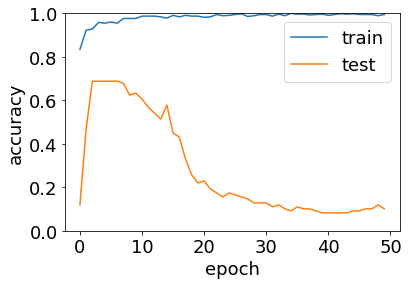

In [77]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0, 1)
plt.show()

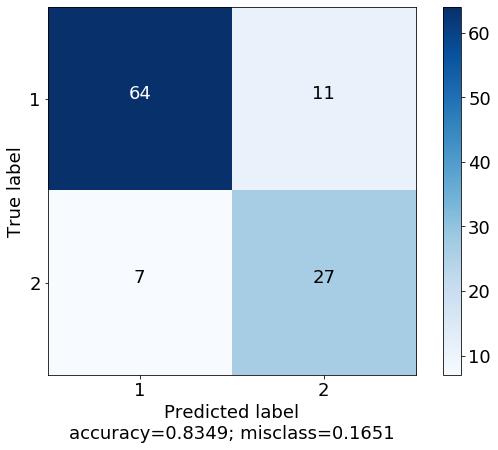

In [78]:
cm = confusion_matrix(y_test, y_pred4)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [114]:
model4.model.save('models/hidden4.h5')

# 3 Hidden Layers

In [79]:
def hidden3(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(BatchNormalization())
    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(BatchNormalization())
    model.add(Dense((hidden_layers*1), activation='relu'))
    model.add(Dropout(dropout))

    model.add(BatchNormalization())
    model.add(Dense((hidden_layers*0.5), activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [80]:
# parameters selected from previous gridsearch
model3 = KerasClassifier(build_fn=hidden3, epochs=50, batch_size=64, optimizer='adam', init='normal')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [81]:
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred3 = model3.predict(X_test)

Train on 554 samples, validate on 109 samples
Epoch 1/50
554/554 [==============================] - 3s 5ms/sample - loss: 0.4853 - accuracy: 0.7816 - val_loss: 1.3624 - val_accuracy: 0.0183
Epoch 2/50
554/554 [==============================] - 0s 369us/sample - loss: 0.3071 - accuracy: 0.8881 - val_loss: 0.8554 - val_accuracy: 0.0826
Epoch 3/50
554/554 [==============================] - 0s 376us/sample - loss: 0.2540 - accuracy: 0.8953 - val_loss: 0.5215 - val_accuracy: 0.1927
Epoch 4/50
554/554 [==============================] - 0s 372us/sample - loss: 0.1781 - accuracy: 0.9278 - val_loss: 0.5616 - val_accuracy: 0.1743
Epoch 5/50
554/554 [==============================] - 0s 385us/sample - loss: 0.1494 - accuracy: 0.9495 - val_loss: 0.4126 - val_accuracy: 0.2294
Epoch 6/50
554/554 [==============================] - 0s 380us/sample - loss: 0.1120 - accuracy: 0.9675 - val_loss: -0.0061 - val_accuracy: 0.5138
Epoch 7/50
554/554 [==============================] - 0s 373us/sample - loss: 0

In [82]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           1       0.86      0.83      0.84        75
           2       0.65      0.71      0.68        34

    accuracy                           0.79       109
   macro avg       0.75      0.77      0.76       109
weighted avg       0.79      0.79      0.79       109



In [83]:
print(confusion_matrix(y_test, y_pred3))

[[62 13]
 [10 24]]


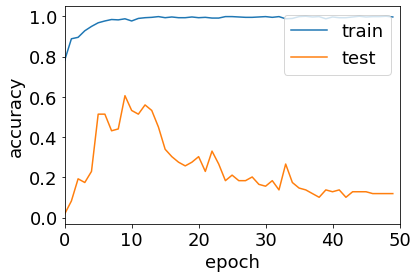

In [84]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim(0, 50)
plt.show()

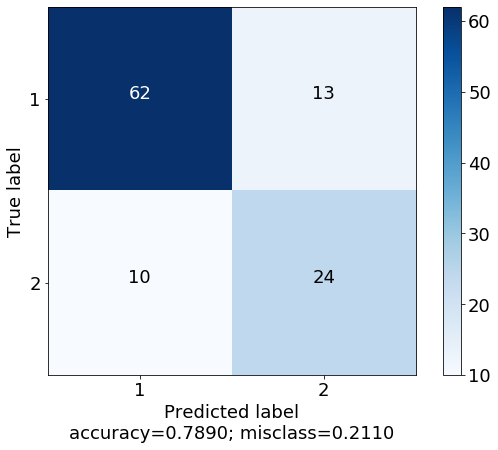

In [85]:
cm = confusion_matrix(y_test, y_pred3)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [ ]:
model3.model.save('models/hidden3.h5')

# 2 Hidden Layers

In [86]:
def hidden2(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense((hidden_layers), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [87]:
# parameters selected from previous gridsearch
model2 = KerasClassifier(build_fn=hidden2, epochs=75, batch_size=32, optimizer='adagrad',init='uniform')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [98]:
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred2 = model2.predict(X_test)

Train on 554 samples, validate on 109 samples
Epoch 1/75
554/554 [==============================] - 2s 4ms/sample - loss: 0.5978 - accuracy: 0.7347 - val_loss: 0.4233 - val_accuracy: 0.6330
Epoch 2/75
554/554 [==============================] - 0s 479us/sample - loss: 0.5402 - accuracy: 0.7816 - val_loss: 0.5435 - val_accuracy: 0.2110
Epoch 3/75
554/554 [==============================] - 0s 478us/sample - loss: 0.4785 - accuracy: 0.7978 - val_loss: 0.5710 - val_accuracy: 0.1560
Epoch 4/75
554/554 [==============================] - 0s 478us/sample - loss: 0.4496 - accuracy: 0.8069 - val_loss: 0.6558 - val_accuracy: 0.0917
Epoch 5/75
554/554 [==============================] - 0s 481us/sample - loss: 0.4313 - accuracy: 0.8123 - val_loss: 0.7617 - val_accuracy: 0.0826
Epoch 6/75
554/554 [==============================] - 0s 497us/sample - loss: 0.4060 - accuracy: 0.8123 - val_loss: 0.7730 - val_accuracy: 0.0826
Epoch 7/75
554/554 [==============================] - 0s 492us/sample - loss: 0.

554/554 [==============================] - 0s 551us/sample - loss: 0.2378 - accuracy: 0.9061 - val_loss: 1.2223 - val_accuracy: 0.0917
Epoch 57/75
554/554 [==============================] - 0s 554us/sample - loss: 0.2531 - accuracy: 0.8845 - val_loss: 1.2548 - val_accuracy: 0.0917
Epoch 58/75
554/554 [==============================] - 0s 549us/sample - loss: 0.2370 - accuracy: 0.8971 - val_loss: 1.3581 - val_accuracy: 0.0826
Epoch 59/75
554/554 [==============================] - 0s 559us/sample - loss: 0.2524 - accuracy: 0.8809 - val_loss: 1.4754 - val_accuracy: 0.0734
Epoch 60/75
554/554 [==============================] - 0s 545us/sample - loss: 0.2373 - accuracy: 0.9007 - val_loss: 1.6575 - val_accuracy: 0.0550
Epoch 61/75
554/554 [==============================] - 0s 543us/sample - loss: 0.2496 - accuracy: 0.8899 - val_loss: 1.5105 - val_accuracy: 0.0734
Epoch 62/75
554/554 [==============================] - 0s 550us/sample - loss: 0.2513 - accuracy: 0.8881 - val_loss: 1.4944 - val_

In [99]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           1       0.88      0.88      0.88        75
           2       0.74      0.74      0.74        34

    accuracy                           0.83       109
   macro avg       0.81      0.81      0.81       109
weighted avg       0.83      0.83      0.83       109



In [102]:
print(confusion_matrix(y_test, y_pred2))

[[66  9]
 [ 9 25]]


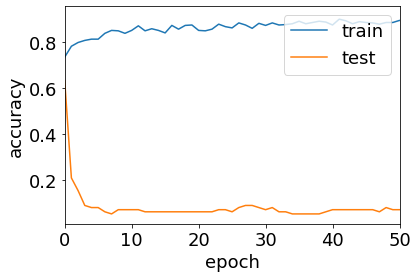

In [103]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim(0, 50)
plt.show()

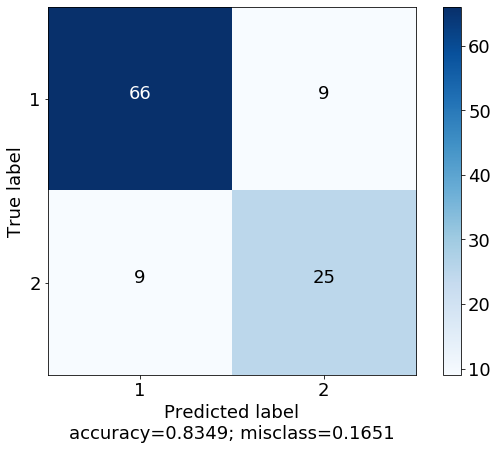

In [104]:
cm = confusion_matrix(y_test, y_pred2)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [54]:
model2.model.save('models/hidden2.h5')

# 1 Hidden Layer

In [59]:
def hidden1(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [60]:
# parameters selected from previous gridsearch
model1 = KerasClassifier(build_fn=hidden1, epochs=50, batch_size=16, optimizer='Adam',init='uniform')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [61]:
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred1 = model1.predict(X_test)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 1s 3ms/sample - loss: 0.5160 - accuracy: 0.7894 - val_loss: 0.1683 - val_accuracy: 0.1376
Epoch 2/50
432/432 [==============================] - 0s 496us/sample - loss: 0.3299 - accuracy: 0.8704 - val_loss: -0.3621 - val_accuracy: 0.6330
Epoch 3/50
432/432 [==============================] - 0s 504us/sample - loss: 0.2892 - accuracy: 0.8727 - val_loss: 0.4693 - val_accuracy: 0.0826
Epoch 4/50
432/432 [==============================] - 0s 520us/sample - loss: 0.2278 - accuracy: 0.9167 - val_loss: 0.4603 - val_accuracy: 0.0734
Epoch 5/50
432/432 [==============================] - 0s 527us/sample - loss: 0.1944 - accuracy: 0.9236 - val_loss: 0.3522 - val_accuracy: 0.0917
Epoch 6/50
432/432 [==============================] - 0s 555us/sample - loss: 0.2453 - accuracy: 0.9028 - val_loss: -0.1920 - val_accuracy: 0.1743
Epoch 7/50
432/432 [==============================] - 0s 545us/sample - loss: 

In [62]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           1       0.87      0.84      0.86        70
           2       0.73      0.77      0.75        39

    accuracy                           0.82       109
   macro avg       0.80      0.81      0.80       109
weighted avg       0.82      0.82      0.82       109



In [63]:
print(confusion_matrix(y_test, y_pred1))

[[59 11]
 [ 9 30]]


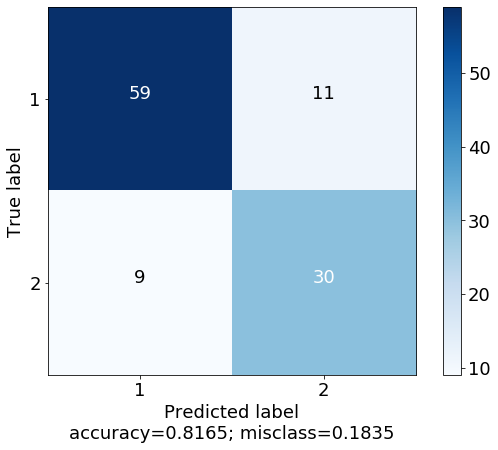

In [66]:
cm = confusion_matrix(y_test, y_pred1)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [65]:
model1.model.save('models/hidden1.h5')